# Notebook for COVID19 Global Forecasting Week 2 Challenge

## Goal - Predict the Following Features for each ID:
* ConfirmedCases
* Fatalities

## External Datasets Utilized - Add into Notebook Manually:
* World Development Indicators: https://www.kaggle.com/theworldbank/world-development-indicators
* WHO Overweight by Country: https://www.kaggle.com/arttua/who-overweight-by-country-2016
* Weather Data: https://www.kaggle.com/hbfree/covid19formattedweatherjan22march24
* Relevant Country Information: https://www.kaggle.com/koryto/countryinfo


In [1]:
#imports
import numpy as np 
import pandas as pd 
import plotly.graph_objects as go
from datetime import datetime, timedelta
import collections
import seaborn
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Input
from keras.callbacks import callbacks, ModelCheckpoint, Callback
from covid_utility import *


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input
/kaggle/input/world-development-indicators
/kaggle/input/world-development-indicators/wdi-excel-zip-59-mb-
/kaggle/input/world-development-indicators/wdi-csv-zip-57-mb-
/kaggle/input/countryinfo
/kaggle/input/covid19formattedweatherjan22march24
/kaggle/input/covid19-global-forecasting-week-2
/kaggle/input/who-overweight-by-country-2016


In [2]:
challenge_data_path = "/kaggle/input/covid19-global-forecasting-week-2"
wdi_data_csv_path = "/kaggle/input/world-development-indicators/wdi-csv-zip-57-mb-"
who_overweight_path = "/kaggle/input/who-overweight-by-country-2016"
weather_path = "/kaggle/input/covid19formattedweatherjan22march24"
country_info_path = "/kaggle/input/countryinfo"
model_weights_path = "/kaggle/output/working"

# Data Collection

## Training Data from the competition itself


In [3]:
challenge_train_df = pd.read_csv(os.path.join(challenge_data_path, "train.csv"))
challenge_test_df = pd.read_csv(os.path.join(challenge_data_path, "test.csv"))
challenge_train_df.tail()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
20575,29366,NaN,Zimbabwe,2020-03-27,5.0,1.0
20576,29367,NaN,Zimbabwe,2020-03-28,7.0,1.0
20577,29368,NaN,Zimbabwe,2020-03-29,7.0,1.0
20578,29369,NaN,Zimbabwe,2020-03-30,7.0,1.0
20579,29370,NaN,Zimbabwe,2020-03-31,8.0,1.0


## World Development Indicators - Non Time Series

In [4]:
wdi_data_df = pd.read_csv(os.path.join(wdi_data_csv_path, 'WDIData.csv'))
print(f"Number of Unique Indicator Codes: {wdi_data_df['Indicator Code'].nunique()}")
print(f"Number of Unique Indicator Names: {wdi_data_df['Indicator Name'].nunique()}")
unique_indicator_names = list(wdi_data_df['Indicator Name'].unique())
wdi_data_df.tail()

Number of Unique Indicator Codes: 1599
Number of Unique Indicator Names: 1599


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
422131,Zimbabwe,ZWE,Women who believe a husband is justified in be...,SG.VAW.NEGL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,21.4,NaN,NaN,NaN,21.4,NaN,NaN,NaN,NaN
422132,Zimbabwe,ZWE,Women who believe a husband is justified in be...,SG.VAW.REFU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,16.9,NaN,NaN,NaN,14.5,NaN,NaN,NaN,NaN
422133,Zimbabwe,ZWE,Women who were first married by age 15 (% of w...,SP.M15.2024.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.9,NaN,NaN,NaN,3.7,NaN,NaN,NaN,NaN
422134,Zimbabwe,ZWE,Women who were first married by age 18 (% of w...,SP.M18.2024.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30.5,NaN,NaN,33.5,32.4,NaN,NaN,NaN,NaN
422135,Zimbabwe,ZWE,Women's share of population ages 15+ living wi...,SH.DYN.AIDS.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,58.2,58.4,58.6,58.8,58.9,58.9,59.0,59.1,NaN,NaN


In [5]:
unique_indicator_names[:5]

['2005 PPP conversion factor, GDP (LCU per international $)',
 '2005 PPP conversion factor, private consumption (LCU per international $)',
 'Access to clean fuels and technologies for cooking (% of population)',
 'Access to electricity (% of population)',
 'Access to electricity, rural (% of rural population)']

## WHO Overweight Data  - Non Time Series

In [6]:
overweight_df = pd.read_csv(os.path.join(who_overweight_path, "WHO_overweightByCountry_2016.csv"))

In [7]:
overweight_df.rename(columns={'Unnamed: 0': 'Country_Region'}, inplace=True)
idx = overweight_df[overweight_df['Country_Region'] == 'United States of America'].index.values[0]
overweight_df.loc[idx, "Country_Region"] = "US"
overweight_df.loc[idx,:]

Country_Region      US
Both.sexes        70.2
Male              74.8
Female            65.8
Name: 186, dtype: object

## Weather Data - Time Series!

In [8]:
weather_df = pd.read_csv(os.path.join(weather_path, "covid_dataset.csv"))

In [9]:
from datetime import timedelta
weather_df.rename(columns={'Country/Region': "Country_Region", 'Province/State': "Province_State",
                          "pop": "Population_Weather"}, inplace=True)
starting_date = datetime(2020, 1, 22)
weather_df['Date'] = weather_df['day'].apply(lambda x: starting_date + timedelta(days=x))
weather_df['Year'] = pd.DatetimeIndex(weather_df['Date']).year
weather_df['Month'] = pd.DatetimeIndex(weather_df['Date']).month
weather_df['Day'] = pd.DatetimeIndex(weather_df['Date']).day

In [10]:
no_province_data = weather_df[weather_df['Province_State'].isna() == True]
province_weather_data = weather_df[weather_df['Province_State'].isna() == False]
# for country in no_province_data['Country_Region'].unique():
#     d = no_province_data[no_province_data['Country_Region'] == country]
#     n_lat, n_long = d.lat.nunique(), d.long.nunique()
#     if n_lat > 1 or n_long > 1:
#         print(f"Country: {country}")
#         print(f"Number of Lat, long: {d.lat.nunique(), d.long.nunique()}")
province_weather_data[province_weather_data["Country_Region"] == "US"].head()

,Province_State,Country_Region,lat,long,day,Population_Weather,urbanpop,density,medianage,smokers,...,restrictions,temperature,humidity,confirmed,deaths,recovered,Date,Year,Month,Day
13664,Alabama,US,32.3182,-86.9023,0,4903185,-999,-999,-999,-999.0,...,-999,8,51,0,0,0,2020-01-22,2020,1,22
13665,Alabama,US,32.3182,-86.9023,1,4903185,-999,-999,-999,-999.0,...,-999,9,86,0,0,0,2020-01-23,2020,1,23
13666,Alabama,US,32.3182,-86.9023,2,4903185,-999,-999,-999,-999.0,...,-999,14,81,0,0,0,2020-01-24,2020,1,24
13667,Alabama,US,32.3182,-86.9023,3,4903185,-999,-999,-999,-999.0,...,-999,11,76,0,0,0,2020-01-25,2020,1,25
13668,Alabama,US,32.3182,-86.9023,4,4903185,-999,-999,-999,-999.0,...,-999,12,79,0,0,0,2020-01-26,2020,1,26


In [11]:
weather_good_cols = ["Country_Region", 'Year', "Month", "Day", "Province_State", "lat", 'long',
                    'Population_Weather', 'smokers', 'restrictions', 'temperature', 'humidity', ]

# weather_df[weather_good_cols].tail()
# weather_df['Province/State'].unique()

## General Country Data  - Non Time Series

In [12]:
country_info_df = pd.read_csv(os.path.join(country_info_path, "covid19countryinfo.csv"))
# country_restrictions_df = pd.read_csv(os.path.join(country_info_path, "restrictions.csv"))

In [13]:
country_info_df.rename(columns={'country': "Country_Region", 'pop': "Population"}, inplace=True)
country_info_good_cols = ["Country_Region",'Population', 'tests', 'density', 'medianage', 'urbanpop', 'sexratio',
                          'lung', 'femalelung', 'malelung']
country_info_df.head()

,region,Country_Region,alpha3code,alpha2code,Population,tests,testpop,density,medianage,urbanpop,...,newdeaths31,newdeaths1,newdeaths2,recovered,critical30,critical31,critical1,critical2,casediv1m,deathdiv1m
0,NaN,Afghanistan,AFG,AF,"38,928,346",NaN,NaN,60.0,18.0,25.0,...,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,6,0.1
1,NaN,Albania,ALB,AL,"2,877,797",NaN,NaN,105.0,36.0,63.0,...,4.0,NaN,1.0,67,7,8,7,7,96,6.0
2,NaN,Algeria,DZA,DZ,"43,851,044",NaN,NaN,18.0,29.0,73.0,...,9.0,14.0,NaN,61,NaN,NaN,NaN,NaN,19,1.0
3,NaN,Andorra,AND,AD,"77,265",NaN,NaN,164.0,45.0,88.0,...,NaN,2.0,1.0,10,10,10,12,12,"5,539",194.0
4,NaN,Antigua and Barbuda,ATG,AG,"97,929",NaN,NaN,223.0,34.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71,NaN


In [14]:
# country_restrictions_df.rename(columns={'country_region': "Country_Region"}, inplace=True)
# country_restrictions_df["Country_Region"].unique()
# state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District ", "of Columbia", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
# cities = ['Atlanta']
# country_restrictions_df["US_State"] = country_restrictions_df['Country_Region'].apply(lambda x: 1 if x in state_names else 0)
# country_restrictions_df["US_City"] = country_restrictions_df['Country_Region'].apply(lambda x: 1 if x in cities else 0)
# country_restrictions_df.head()

# Data Processing
## Note there needs to be an emphasis on time related information

In [15]:
df_1 = challenge_train_df.copy()

In [16]:
#Date Splitting
df_1['Date']= pd.to_datetime(df_1['Date'])
df_1['Year'] = pd.DatetimeIndex(df_1['Date']).year
df_1['Month'] = pd.DatetimeIndex(df_1['Date']).month
df_1['Day'] = pd.DatetimeIndex(df_1['Date']).day
print(f"Unique Years: {df_1['Year'].unique()}")
print(f"Unique Months: {df_1['Month'].unique()}")

Unique Years: [2020]
Unique Months: [1 2 3]


In [17]:
#Bring Population and other general information
df_2 = df_1.merge(right=country_info_df[country_info_good_cols], how='left', on='Country_Region')

In [18]:
#Obesity Information
df_3 = df_2.merge(right=overweight_df, how='left', on='Country_Region')
non_time_series_cols = ["Country_Region", 'Population', "tests", 'density', 'medianage', 
                       'urbanpop', 'sexratio', 'lung', 'femalelung', 'malelung', 'Both.sexes', 'Male', 'Female']
non_time_series_df = df_3[non_time_series_cols].copy()
non_time_series_df.drop_duplicates(inplace=True)

In [19]:
#Time Series weather data
time_series_df = df_1.merge(right=weather_df[weather_good_cols], how='left', on=['Province_State', "Country_Region","Month", "Day", "Year"])

In [20]:
print(time_series_df.shape)
print(time_series_df.columns)
time_series_df[(time_series_df['Country_Region'] == 'US') & (time_series_df['Province_State'] == 'Alabama')].sort_values(by=['Month', 'Day'], ascending=[False, False]).head(8)

(20580, 16)
Index(['Id', 'Province_State', 'Country_Region', 'Date', 'ConfirmedCases',
       'Fatalities', 'Year', 'Month', 'Day', 'lat', 'long',
       'Population_Weather', 'smokers', 'restrictions', 'temperature',
       'humidity'],
      dtype='object')


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,Year,Month,Day,lat,long,Population_Weather,smokers,restrictions,temperature,humidity
15749,22470,Alabama,US,2020-03-31,987.0,23.0,2020,3,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15748,22469,Alabama,US,2020-03-30,899.0,10.0,2020,3,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15747,22468,Alabama,US,2020-03-29,825.0,10.0,2020,3,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15746,22467,Alabama,US,2020-03-28,694.0,4.0,2020,3,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15745,22466,Alabama,US,2020-03-27,587.0,4.0,2020,3,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15744,22465,Alabama,US,2020-03-26,517.0,1.0,2020,3,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15743,22464,Alabama,US,2020-03-25,381.0,1.0,2020,3,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15742,22463,Alabama,US,2020-03-24,242.0,0.0,2020,3,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
time_series_df.sort_values(by=['Month', "Date"], inplace=True)
time_series_df.reset_index(inplace=True)
time_series_df.drop('index', axis=1, inplace=True)

In [22]:
print(non_time_series_df.shape)
print(non_time_series_df.columns)
non_time_series_df.head(8)

(193, 13)
Index(['Country_Region', 'Population', 'tests', 'density', 'medianage',
       'urbanpop', 'sexratio', 'lung', 'femalelung', 'malelung', 'Both.sexes',
       'Male', 'Female'],
      dtype='object')


,Country_Region,Population,tests,density,medianage,urbanpop,sexratio,lung,femalelung,malelung,Both.sexes,Male,Female
0,Afghanistan,"38,928,346",NaN,60.0,18.0,25.0,1.03,37.62,36.31,39.33,19.7,17.1,22.2
70,Albania,"2,877,797",NaN,105.0,36.0,63.0,0.98,11.67,7.02,17.04,58.7,64.9,52.8
140,Algeria,"43,851,044",NaN,18.0,29.0,73.0,1.03,8.77,5.03,12.81,60.7,56.7,64.8
210,Andorra,"77,265",NaN,164.0,45.0,88.0,1.06,NaN,NaN,NaN,68.1,74.5,61.9
280,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.9,17.2,30.4
350,Antigua and Barbuda,"97,929",NaN,223.0,34.0,26.0,0.90,11.76,7.67,18.78,48.4,40.2,56.3
420,Argentina,"45,195,774",NaN,17.0,32.0,93.0,0.98,29.27,20.16,42.59,63.4,66.4,60.5
490,Armenia,"2,963,243",694.0,104.0,35.0,63.0,0.94,23.86,16.17,35.99,55.7,54.6,56.9


# Data Exploration - US Specific

In [23]:
us_data = time_series_df[time_series_df['Country_Region'] == 'US']

In [24]:
print(f"Number of states represented in the US: {us_data['Province_State'].nunique()}")
us_data['Province_State'].unique()

Number of states represented in the US: 54


array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming'], dtype=object)

In [25]:
new_york_fig = cumalitive_cases_plot(usa_df=us_data, state='New York')
new_york_fig

In [26]:
#All US Plot
last_date = us_data['Date'].max()
top_5_worst_current_states = us_data[us_data['Date'] == last_date].sort_values('ConfirmedCases', ascending=False).head()

top_5_fig = create_top_5_states_plot(us_data, top_5_worst_current_states)
top_5_fig    
    

# Data Preparation

In [27]:
first_case_df = us_data[us_data['ConfirmedCases'] > 0].sort_values('Date').reset_index()
first_reported_case_date = first_case_df.loc[0,"Date"]
first_state = first_case_df.loc[0, "Province_State"]
print(f"{first_state} had the first Reported Case: {first_reported_case_date}")

Arizona had the first Reported Case: 2020-03-10 00:00:00


## Times to Create our Dataset that reflects a sliding window

In [28]:
sliding_window = 3

In [29]:
X = create_training_dataset(first_reported_case_date, us_data, sliding_window)
shuffled_X = shuffle(X).copy()
shuffled_X.reset_index(inplace=True)
shuffled_X.rename(columns={'index': "Old Index"},inplace=True)

states = list(shuffled_X.columns)[14:]
states_dict = {idx: state for idx, state in enumerate(states)}

In [30]:
Y = shuffled_X[['ConfirmedCases', 'Fatalities']]

In [70]:
train_X = shuffled_X.copy()
train_X.drop(labels=['Old Index', 'Province_State', 'Date', 'ConfirmedCases', 'Fatalities'],inplace=True,axis=1)
good_col_order = list(train_X.columns)
train_X = train_X.to_numpy()
train_Y = Y.to_numpy()
input_dimension = train_X.shape[-1]
train_X.shape, train_Y.shape

((1188, 63), (1188, 2))

### If new data add it here using the create_new_training_point method

In [71]:
# x,y = create_new_training_point(shuffled_X=shuffled_X, state="New York", date=datetime(2020,4,1),
#                                 cases=92381,fatalities=2468, first_reported_case_date=first_reported_case_date,
#                                 sliding_window=3, good_col_order=good_col_order,
#                               states_dict=states_dict,humidity=None, temp=None)
# train_X = np.vstack((train_X, x))
# train_Y = np.vstack((train_Y, y))
# train_X.shape, train_Y.shape


# Model Attempt 1a

## US Data only, time series sliding window - linear Model

In [82]:
from keras.constraints import non_neg

linear_model = Sequential()
linear_model.add(Dense(input_dim=input_dimension, \
                       units=input_dimension, activation='elu', \
                       use_bias=True, kernel_initializer="random_normal",\
                       bias_initializer='zeros'
                      ))
linear_model.add(Dense(units=50, activation='elu'))
linear_model.add(Dropout(rate=0.25))
linear_model.add(Dense(units=50, activation='elu'))
linear_model.add(Dropout(rate=0.2))
linear_model.add(Dense(units=50, activation='elu'))
linear_model.add(Dropout(rate=0.15))
linear_model.add(Dense(units=50, activation='elu'))
linear_model.add(Dropout(rate=0.1))
linear_model.add(Dense(units=50, activation='elu'))
linear_model.add(Dropout(rate=0.05))
linear_model.add(Dense(units=5, activation='elu'))
linear_model.add(Dense(units=2, activation='relu', use_bias=False, kernel_constraint=non_neg()))
linear_model.compile(loss='mean_squared_error', optimizer='Adamax')
# linear_model.summary()
    

In [83]:
checkpoint = ModelCheckpoint("best_model_1a.hdf5", monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto', period=1)
linear_model.fit(x=train_X, y=train_Y, batch_size=32,
                 epochs=250, verbose=0, validation_split=0.25, callbacks=[checkpoint])

Minimum Training Loss (Square Rooted): 265.4276918045091
Occured at Epoch: 155
Minimum Validation Loss (Square Rooted): 211.79210488625634
Occured at Epoch: 202


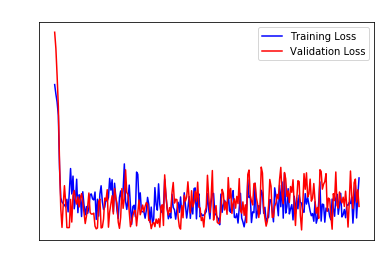

In [84]:
create_training_val_loss_plot(linear_model)


## Prediction on Exisiting Data

In [87]:
model_1a = load_model("../working/best_model_1a.hdf5")
random_int = np.random.randint(train_X.shape[0])
new_york_max_idx = shuffled_X[shuffled_X['Province_State']== 'New York'].sort_values('Date', ascending=False).index.values[0] + 1
case_predictions, death_predictions, prediction_state, prediction_date, actual_cases, actual_deaths = \
    make_prediction_existing_data(train_X, train_Y, model_1a, random_int, states_dict,
                                  first_reported_case_date, model_type='simple', verbose=True)

Date of Predicition: 2020-03-10 00:00:00
State of Prediction: Connecticut


Confirmed Cases Prediction: 76.79
Actual Confirmed Cases: 68.0


Confirmed Fatalities Prediction: 0.75
Actual Confirmed Fatalities: 0.0


# Model Attempt 1B

## Same linear model but applied weight scaling to the two outputs

In [88]:
base_model = Sequential()
base_model.add(Dense(input_dim=input_dimension, \
                       units=input_dimension, activation='elu', \
                       use_bias=True, kernel_initializer="random_normal",\
                       bias_initializer='zeros'
                      ))
base_model.add(Dense(units=50, activation='elu'))
base_model.add(Dropout(rate=0.25))
base_model.add(Dense(units=50, activation='elu'))
base_model.add(Dropout(rate=0.2))
base_model.add(Dense(units=50, activation='elu'))
base_model.add(Dropout(rate=0.15))
base_model.add(Dense(units=50, activation='elu'))
base_model.add(Dropout(rate=0.1))
base_model.add(Dense(units=50, activation='elu'))
base_model.add(Dropout(rate=0.05))
base_model.add(Dense(units=5, activation='elu'))

main_input = Input(shape=(input_dimension,), dtype='float32', name='main_input')
x = base_model(main_input)
confirmed_cases_output = Dense(units=1, activation='linear', use_bias=False, name='cases_output')(x)
confirmed_fatalities_output = Dense(units=1, activation='relu', use_bias=False,
                                    kernel_constraint=non_neg(), name='death_output')(x)

model_1b = Model(inputs=main_input, outputs=[confirmed_cases_output, confirmed_fatalities_output])

In [89]:
#Use this if want a moving loss variable - cant save model using this
from keras import backend as K
cases_loss = K.variable(0.5)
deaths_loss = K.variable(1)

class MyCallback(Callback):
    def __init__(self, cases_loss, deaths_loss):
        self.cases_loss = cases_loss
        self.deaths_loss = deaths_loss
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 25 == 0:
            self.cases_loss = self.cases_loss + 0.1
            self.deaths_loss = self.deaths_loss + 0.5

### Compile Model and note the weights of fatalities output

In [90]:
model_1b.compile(optimizer='Adamax',
              loss={'cases_output': 'mean_squared_error', 'death_output': 'mean_squared_error'},
              loss_weights={'cases_output': 1, 'death_output': 90})

In [91]:
checkpoint_2 = ModelCheckpoint("best_model_1b.hdf5", monitor='val_loss', verbose=0,
    save_best_only=True, mode='auto', period=1)

model_1b.fit({'main_input': train_X},
          {'cases_output': train_Y[:,0], 'death_output': train_Y[:,1]},
          epochs=250, batch_size=32, verbose=0, validation_split=0.25,
#           callbacks=[MyCallback(cases_loss, deaths_loss)], #use this if want to adjust loss weights
          callbacks=[checkpoint_2]
         )

Minimum Training Loss (Square Rooted): 480.5103881967415
Occured at Epoch: 224
Minimum Validation Loss (Square Rooted): 407.5990576831185
Occured at Epoch: 46


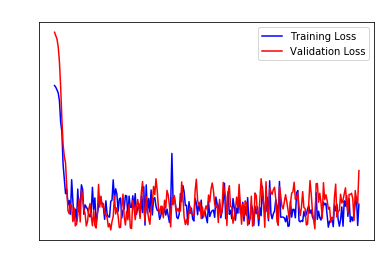

In [92]:
create_training_val_loss_plot(model_1b)

In [93]:
model_1b = load_model("../working/best_model_1b.hdf5")
random_int = np.random.randint(train_X.shape[0])
make_prediction_existing_data(train_X, train_Y, model_1b, random_int, states_dict,
                              first_reported_case_date, model_type='complex', verbose=True)

Date of Predicition: 2020-03-10 00:00:00
State of Prediction: North Dakota


Confirmed Cases Prediction: 6.42
Actual Confirmed Cases: 0.0


Confirmed Fatalities Prediction: 0.00
Actual Confirmed Fatalities: 0.0


(6.4194636, 0.0, 'North Dakota', Timestamp('2020-03-10 00:00:00'), 0.0, 0.0)

## Compare the Models

In [94]:
models = [load_model("../working/best_model_1a.hdf5"), load_model("../working/best_model_1b.hdf5")]
random_int = np.random.randint(train_X.shape[0])
compare_models(train_X, train_Y, models, random_int, states_dict, first_reported_case_date)

Prediction State: Maryland
Prediction Date: 2020-03-11 00:00:00
Actual Cases: 193.0
Actual Deaths: 2.0


Model: 1
Predicted Cases: 191.38905334472656
Predicted Deaths: 2.9619908332824707


Model: 2
Predicted Cases: 167.43617248535156
Predicted Deaths: 2.521221399307251


Best Case Prediction Model: Model 0 with a difference of 1.61
Best Fatality Prediction Model: Model 1 with a difference of 0.52


({0: {'Cases': 191.38905,
   'Deaths': 2.9619908,
   'Case Difference': 1.6109466552734375,
   'Death Difference': 0.9619908332824707},
  1: {'Cases': 167.43617,
   'Deaths': 2.5212214,
   'Case Difference': 25.563827514648438,
   'Death Difference': 0.521221399307251}},
 191.38905,
 2.5212214)

## Create Predictions for Top 6 Affected States

In [95]:
ny_df = create_state_prediction_df(train_X, train_Y, shuffled_X, "New York",
                                   models, states_dict, first_reported_case_date)
ca_df = create_state_prediction_df(train_X, train_Y, shuffled_X, "California",
                                   models, states_dict, first_reported_case_date)
nj_df = create_state_prediction_df(train_X, train_Y, shuffled_X, "New Jersey",
                                   models, states_dict, first_reported_case_date)
mi_df = create_state_prediction_df(train_X, train_Y, shuffled_X, "Michigan",
                                   models, states_dict, first_reported_case_date)
fl_df = create_state_prediction_df(train_X, train_Y, shuffled_X, "Florida",
                                   models, states_dict, first_reported_case_date)
ma_df = create_state_prediction_df(train_X, train_Y, shuffled_X, "Massachussetts",
                                   models, states_dict, first_reported_case_date)
ca_df.head()

,Date,Predicted_Cases,Predicted_Deaths,Province_State
0,2020-03-10,7.869834,0.829133,California
1,2020-03-11,136.133621,1.993897,California
2,2020-03-12,217.084641,3.607015,California
3,2020-03-13,275.660370,4.332447,California
4,2020-03-14,348.199493,5.545189,California


In [96]:
# from plotly.subplots import make_subplots
ny_fig = plot_prediction_actual_comparision(ny_df, us_data, "New York", first_reported_case_date)
nj_fig = plot_prediction_actual_comparision(nj_df, us_data, "New Jersey", first_reported_case_date)
ca_fig = plot_prediction_actual_comparision(ca_df, us_data, "California", first_reported_case_date)
mi_fig = plot_prediction_actual_comparision(mi_df, us_data, "Michigan", first_reported_case_date)
fl_fig = plot_prediction_actual_comparision(fl_df, us_data, "Florida", first_reported_case_date)
ma_fig = plot_prediction_actual_comparision(ma_df, us_data, "Massachusetts", first_reported_case_date)

In [97]:
ny_fig.show()

# Test Predictions on April Data

In [98]:
new_york_confirmed_april_1, new_york_confirmed_death_april_1 = 92381, 2468

In [99]:
predict_states = {'New York': ny_df, "California": ca_df, "New Jersey": nj_df}
for state in predict_states.keys():
    all_state_predictions_to_date = \
        create_predictions_up_to(previous_state_predictions=predict_states[state], first_reported_case_date=first_reported_case_date,
                                 last_date=datetime(2020,4,2), state=state, shuffled_X=shuffled_X,
                                     sliding_window=3, good_col_order=good_col_order, states_dict=states_dict,
                                     model=model_1b, model_type='complex')
    fig = plot_prediction_actual_comparision(all_state_predictions_to_date, us_data, state, first_reported_case_date)
    fig.show()

# Model Attempt 2

## LSTM with Attention
